Below are the pre-requisite installs for the file, as the data was imported by the json API token method for accessibility.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Model
from glob import glob

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization,GlobalAveragePooling2D
)
from keras.layers import AveragePooling2D, MaxPooling2D

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle-2.json"

In [ ]:
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /content/drive/MyDrive/kaggle-2.json. Or use the environment method.


In [ ]:
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia --unzip --force

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /content/drive/MyDrive/kaggle-2.json. Or use the environment method.


In terms of data cleaning/preprocessing:

From the assignment brief we are already informed that all images are already the same size, as such no adjustments were required in this case.

To counteract the issue of images being in a different rotation, we employed data augmentation in order to create copies of the data in different rotations, in order to get our models "used to" images in different rotations and other issues, so that greater accuracy can be achieved in the long-run.

The below paths were simply copied from the left hand side folder:

In [ ]:
train_Path = '/content/drive/MyDrive/Data/train'
test_Path = '/content/drive/MyDrive/Data/test'

Next, in order to understand the data we are working with, some brief visualisation is beneficial:

In [ ]:
print("Train set:\n========================================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(train_Path, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(train_Path, 'NORMAL')))}")
print(f"COVID-19 = {len(os.listdir(os.path.join(train_Path, 'COVID19')))}")

print()

print("Test set:\n========================================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(test_Path, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_Path, 'NORMAL')))}")
print(f"COVID-19 = {len(os.listdir(os.path.join(test_Path, 'COVID19')))}")




Train set:
PNEUMONIA = 3418
NORMAL = 1266
COVID-19 = 460

Test set:
PNEUMONIA = 855
NORMAL = 317
COVID-19 = 116


Now that we have the counts of the image types, visualising a sample from each class allows us to take a closer look at the differences, and gives a rough indicator of how difficult it is to seperate the images given they are all of the same idea (chest x-rays).

An additional benefit of showing the samples also allows us to see if the data was loaded correctly, and accessible.

Pneumonia chest x-ray samples


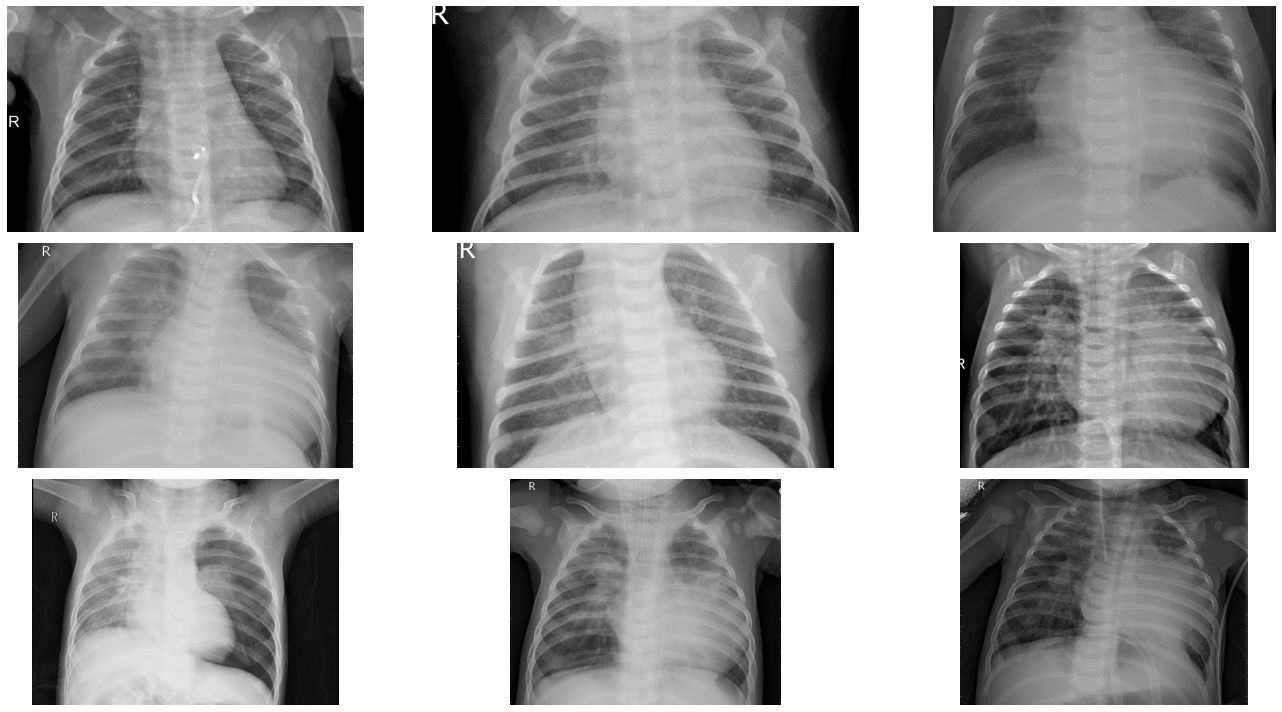

In [ ]:
from matplotlib.image import imread

pneumonia = os.listdir("/content/drive/MyDrive/Data/train/PNEUMONIA")
pneumonia_dir = "/content/drive/MyDrive/Data/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

print("Pneumonia chest x-ray samples")

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

Normal chest x-ray samples


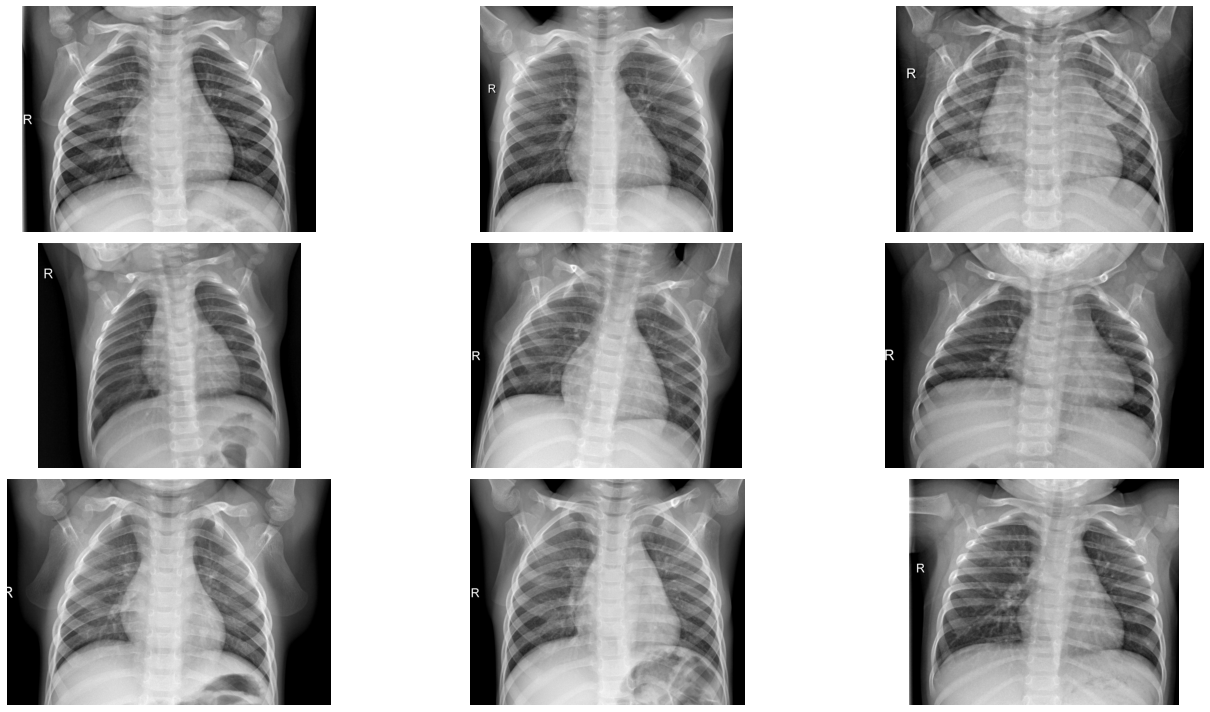

In [ ]:
normal = os.listdir("/content/drive/MyDrive/Data/train/NORMAL")
normal_dir = "/content/drive/MyDrive/Data/train/NORMAL"

plt.figure(figsize=(20, 10))

print("Normal chest x-ray samples")

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

COVID-19 chest x-ray samples


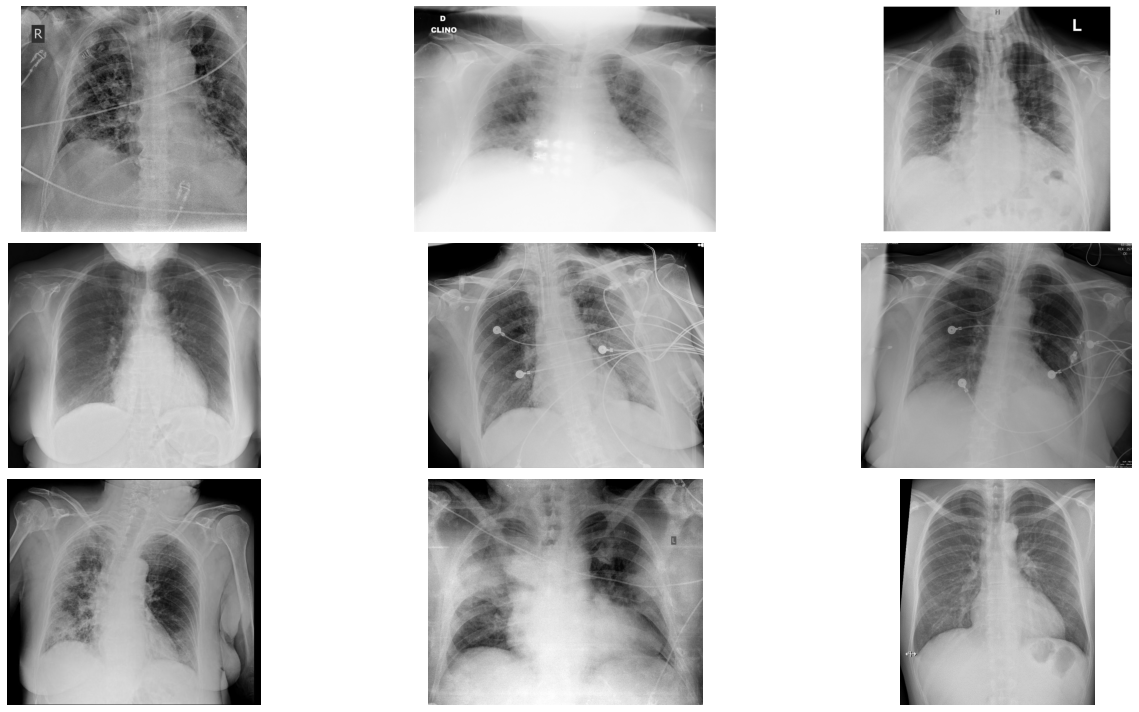

In [ ]:
covid19 = os.listdir("/content/drive/MyDrive/Data/train/COVID19")
covid19_dir = "/content/drive/MyDrive/Data/train/COVID19"

plt.figure(figsize=(20, 10))

print("COVID-19 chest x-ray samples")

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(covid19_dir, covid19[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

Next, the data is augmented using Keras' ImageDataGenerator:


In [ ]:
train_datagen = ImageDataGenerator(rotation_range=90,
                              fill_mode= 'nearest',
                              height_shift_range=0.3,
                              width_shift_range=0.3,
                              horizontal_flip= False,
                              vertical_flip= False,
                              brightness_range=[0.5,1.5],
                              zoom_range=0.2,
                              rescale=1./225,
                              samplewise_std_normalization=True,
                                   )


In [ ]:
test_datagen2 = ImageDataGenerator(rotation_range=90,
                              fill_mode= 'nearest',
                              height_shift_range=0.3,
                              width_shift_range=0.3,
                              horizontal_flip= False,
                              vertical_flip= False,
                              brightness_range=[0.5,1.5],
                              zoom_range=0.2,
                              rescale=1./225,
                              samplewise_std_normalization= True,
                              featurewise_std_normalization=True
                                   )

Creating ResNet and VGG net


In [ ]:
baseModel1 = VGG16(input_shape=(224,224,3), weights='imagenet',include_top=False)
baseModel2 = ResNet50(input_shape=(224,224,3),weights='imagenet',include_top=False)

for layer in baseModel1.layers:
  layer.trainable = False

for layer in baseModel2.layers:
  layer.trainable = False


classes = glob('/content/drive/MyDrive/Data/train/*')

vgg_last_layer = Flatten()(baseModel1.output)
resnet_last_layer = Flatten()(baseModel2.output)

vgg_prediction = Dense(len(classes), activation='softmax')(vgg_last_layer)
resnet_prediction = Dense(len(classes), activation='softmax')(resnet_last_layer)

VGG = Model(inputs = baseModel1.input, outputs= vgg_prediction)
ResNet = Model(inputs = baseModel2.input, outputs= resnet_prediction)



Next, by examining the summary of the models after altering the final layer, we can observe if the final layer has an output of 3 instead of 1000, which is the base version of this model:

In [ ]:
VGG.summary()

In [ ]:
ResNet.summary()

Below is the compiling of the model, adding in:

Optimiser = Adam was selected 

Loss function = Categorical crossentropy - 

Metrics = Examining the overall accuracy for part 1 was our only concern, as this was an exercise of simply examining how well the imagenet weights and base variant of the models worked with our dataset (with the minor alteration of 3 classes down from 1000)

In [ ]:
from tensorflow.keras.optimizers import Adam


opt=Adam(learning_rate=0.0001)

VGG.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
ResNet.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])





training_set = train_datagen.flow_from_directory(train_Path,
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 shuffle=True)



# This below version is just for the case in which we clean the test data beforehand:
test_set2 = test_datagen2.flow_from_directory(test_Path,
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            seed= 42,
                                            shuffle = False)


Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


Step 1 of assignment - Testing base variants of VGG and ResNet on our models, with the only adjustment being the output layer size being converted from 1000 to 3 (in respect to the our class count).

The results largely match our expectations, as the weights of these models were trained for a differing task and as such would perform poorly on our chest x-ray dataset as it has not been fitted to this task.



In [ ]:
VGG16_test = VGG.evaluate(test_set2) 

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


41/41 [==============================] - 614s 15s/step - loss: 1.0717 - accuracy: 0.4286


Whilst this above result may be somewhat high for the pre-trained model, it is important to understand that despite the fact we set a random seed prior, this result fluctuated on different runs of the notebook. Sometimes VGG would achieve roughly 24%-11%, this inconsistency details how the model is not particularly well suited to our data despite a somewhat misleading result here

In [ ]:

predictor = VGG.predict_generator(test_set2)
predicted_classes = np.argmax(predictor, axis=1)

actual = test_set2.classes
class_labels = list(test_set2.class_indices.keys())


report = classification_report(actual, predicted_classes, target_names=class_labels)
print(report) 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


              precision    recall  f1-score   support

     COVID19       0.07      0.08      0.08       116
      NORMAL       0.25      0.41      0.31       317
   PNEUMONIA       0.66      0.49      0.56       855

    accuracy                           0.44      1288
   macro avg       0.33      0.33      0.32      1288
weighted avg       0.51      0.44      0.46      1288



As observed, the above results in terms of the classificaiton report were considerably decent, which was not we anticipated. 

In [ ]:
ResNet_test = ResNet.evaluate(test_set2)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


41/41 [==============================] - 220s 5s/step - loss: 1.8407 - accuracy: 0.1452


In [ ]:
predictor2 = ResNet.predict_generator(test_set2)
predicted_classes2 = np.argmax(predictor2, axis=1)

actual = test_set2.classes
class_labels = list(test_set2.class_indices.keys())


report = classification_report(actual, predicted_classes2, target_names=class_labels)
print(report) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


              precision    recall  f1-score   support

     COVID19       0.09      0.97      0.17       116
      NORMAL       0.05      0.00      0.01       317
   PNEUMONIA       0.87      0.08      0.15       855

    accuracy                           0.14      1288
   macro avg       0.34      0.35      0.11      1288
weighted avg       0.60      0.14      0.12      1288




Below is a modification of our ResNet model (VGG16 new model is in the other notebook in the file):

MaxPooling layer: This layer was selected over averagepooling2D due to max pooling's speciality in highlighting specific components of the images regardless of location, whereas averagepooling is more "broad" and fails to pinpoint the sharper details. We felt this would be an interesting addition to the model framework.

Dropout: This was introduced to counteract the problem of overfitting, that is common with CNN's of ResNet's size. The value was set to the benchmark of 0.5, which tends to be sufficient for the majority of CNN's.


In [ ]:
improved_ResNet = ResNet50(input_shape=(224,224,3),weights='imagenet',include_top=False)


improved_ResNet_outerlayer = improved_ResNet.output
improved_ResNet_outerlayer = MaxPooling2D(pool_size=(2,2))(improved_ResNet_outerlayer)
improved_ResNet_outerlayer = Dropout(0.5)(improved_ResNet_outerlayer)
improved_ResNet_outerlayer = Flatten()(improved_ResNet_outerlayer)



predictor = Dense(len(classes),activation='softmax')(improved_ResNet_outerlayer)

enhanced_Resnet = Model(inputs=improved_ResNet.input,outputs = predictor)

enhanced_Resnet.summary()

In [ ]:

enhanced_Resnet.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

z = enhanced_Resnet.fit_generator(generator=training_set,epochs=5,verbose=1,validation_data=test_set2)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/5
161/161 [==============================] - ETA: 0s - loss: 0.9420 - accuracy: 0.7994 

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


161/161 [==============================] - 3629s 22s/step - loss: 0.9420 - accuracy: 0.7994 - val_loss: 3.0178 - val_accuracy: 0.2422
Epoch 2/5
161/161 [==============================] - 3548s 22s/step - loss: 0.3454 - accuracy: 0.9007 - val_loss: 3.0069 - val_accuracy: 0.6638
Epoch 3/5
161/161 [==============================] - 3553s 22s/step - loss: 0.2529 - accuracy: 0.9172 - val_loss: 2.1738 - val_accuracy: 0.6887
Epoch 4/5
161/161 [==============================] - 3547s 22s/step - loss: 0.2444 - accuracy: 0.9238 - val_loss: 1.5040 - val_accuracy: 0.7197
Epoch 5/5
161/161 [==============================] - 3536s 22s/step - loss: 0.1918 - accuracy: 0.9292 - val_loss: 0.3899 - val_accuracy: 0.8672


In [ ]:
updated_ResNet_test = enhanced_Resnet.evaluate(test_set2)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


41/41 [==============================] - 214s 5s/step - loss: 0.4172 - accuracy: 0.8696


In [ ]:
final_prediction = enhanced_Resnet.predict_generator(test_set2)
predicted_classes_final = np.argmax(final_prediction, axis=1)

actual = test_set2.classes
class_labels = list(test_set2.class_indices.keys())


report = classification_report(actual, predicted_classes_final, target_names=class_labels)
print(report) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


              precision    recall  f1-score   support

     COVID19       0.89      0.97      0.93       116
      NORMAL       0.96      0.53      0.69       317
   PNEUMONIA       0.85      0.98      0.91       855

    accuracy                           0.87      1288
   macro avg       0.90      0.83      0.84      1288
weighted avg       0.88      0.87      0.86      1288



Enhanced resnet stats:

Train accuracy after 5 epoch: 92%
Test accuracy: 87%

Overall, these results likely would of improved with higher epochs, however with time and runtime being a significant issue with colab, 5 was the only option for this colab work.